<a href="https://colab.research.google.com/github/Ayan-Vishwakarma/Keras-Implementation-of-Dense-and-DC-NSGAN-WGAN-WGANGP-etc/blob/main/WGAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import time

In [ ]:
(xt,_),(_,_) = keras.datasets.mnist.load_data()
xt.resize((60000,28,28,1))
xt = xt/127.5 - 1.
assert (np.max(xt) == 1. and np.min(xt) == -1.)

11493376/11490434 [==============================] - 0s 0us/step


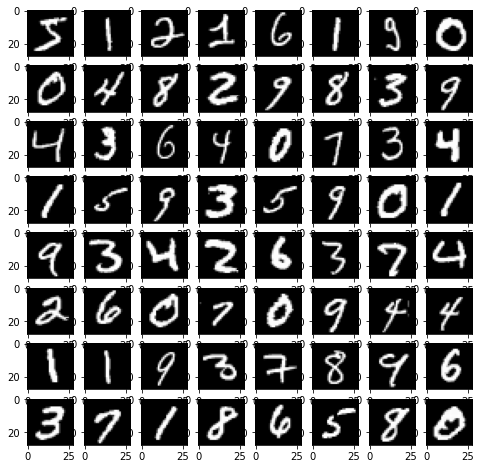

In [ ]:
fig,ax = plt.subplots(8,8,figsize=(8,8))
 
for i in range(64):
  ax[i%8,i//8].imshow(xt[i].reshape((28,28)),cmap="gray")

In [ ]:
def sample_images(generator):
  imgs = generator.predict(np.random.randn(16,z))
  fig,ax = plt.subplots(4,4,sharex=True,sharey=True,figsize = (4,4))
  for i in range(16):
    ax[i%4,i//4].imshow(imgs[i].reshape(28,28),cmap="gray")

Note: All the models are run for strictly less than 10,000 iterations,each with batch_size not more than 128 ,i.e, equivalent to  **less than 10 epochs** through the training data. Running upto 50 epochs can surely create great images, but training time will be just too high for google-colab's non-premium version.Even if a single model can be run for 50 epochs, the other model's performance will be highly inferior so only 10 epochs are taken into account.

# WGAN-GP

By Kantrovich-Rubinstein duality, we can estimate the EM-distance by a function f* named critic belonging to set of all 1-Lipschtiz function, that maximize the RHS term in the below equation.However in practice, we need to maximize the EM-distance, so any set of K-Lipschitz funtion with work with K>0.

The set of K-lipschitz functions is described by a feedforward neural network, where the right critic is found by gradient descent of this neural network. However to make the neural network describe only K-lipschtiz functions, weight clipping was applied. 

However in practice, as the clipping_value decreases, this neural network is unable to describe/converge-to the optimal critic function that estimates K times EM distance.

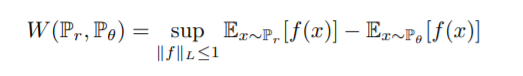

The reqirement of K-Lipschitz [ 1-Lipschitz in the above equation] is fulfilled by a different approach.Instead of applying weight-clipping, Gradient penalty is applied. 

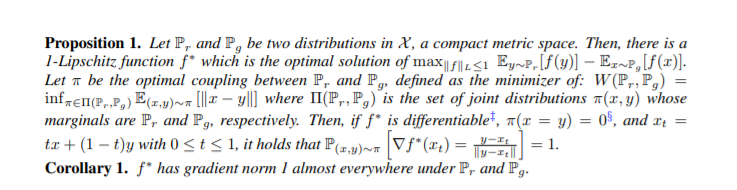

From the above theorem, it was proved in https://arxiv.org/pdf/1704.00028.pdf that the optimal critic will have gradient of norm 1 everywhere in the straight line joining the point of real image to a fake image in compact space X. 

In gradient penalty, an additional loss is added to the original critic loss which penalizes the network if the norm is not equal to 1 given by the below equation in https://arxiv.org/pdf/1704.00028.pdf.

However, putting gradients equal to ((y-xt) / ||y - xt||) does not seems to work.

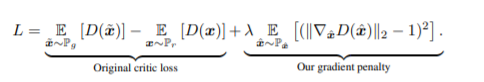

Wasserstein-0 distance gives a relative measure of model's convergence.So the loss can equivalently used to measure the relative convergence of the model. However in WGAN-weight-clipping this behaviour was harder to attain as there was a huge variance in the loss measured.However, with Gradient Clipping, this loss is decreasing with uniformity meaning better convergence and stability and symbolizing it's superior behavior than weight clipping, making NS-GAN and WGAN-GP the most popular loss functions.

### Earth Mover Loss and wgangp_training_loop

Since in Eager mode, Gradient Tape is required to make computational graphs and calculate gradients, Gradient penalty was defined inside the training loop rather than keras custom loss function to keep the discriminator model simple (Else branching may be required in discriminator model which may require to modify the dataset and checking the validity of inputs in discriminator as GP requires x and X_generated in same batch_size )

In [ ]:
def EM(labels,logits):
  return - tf.reduce_sum(labels * logits) / (tf.reduce_sum(labels) + 1e-10)  + tf.reduce_sum((1. - labels) * (logits)) / (tf.reduce_sum((1. - labels)) + 1e-10)

In [ ]:
def wgangp_train(n_iter,n_critic,lmbda,optimizer,batch_size,sampling_interval,disc_weight):
  label_discriminator = np.concatenate([np.ones(batch_size),np.zeros(batch_size)],axis=0)
  label_generator = np.ones(batch_size)
  losses = []
  assert discriminator.trainable == False
 
  for i in range(n_iter):
 
    for j in range(n_critic):
 
      ################################ Original Critic Loss ############################################
      
      x = xt[np.random.randint(len(xt),size= batch_size)]
      x_ = generator(np.random.randn(batch_size,z))
      loss = discriminator.train_on_batch(np.concatenate([x,x_],axis=0),label_discriminator)
      
      t = tf.random.uniform((batch_size,1,1,1))
      xche = t*x + (1-t)*x_
      
      ################################# GRADIENT_PENALTY ###############################################
 
      with tf.GradientTape(watch_accessed_variables=True,persistent = True) as Tape:
        xche = tf.Variable(xche)
        Tape.watch(xche)
        with tf.GradientTape(watch_accessed_variables=True,persistent=True) as tape:
          tape.watch(xche)
          y =  discriminator(xche)
        Dx = tape.gradient(y,xche)
        GP_loss = lmbda * tf.math.reduce_mean((tf.math.reduce_euclidean_norm(Dx,axis=[1,2,3]) - 1.)**2)
      
      losses.append([loss,GP_loss.numpy()])
      grads = Tape.gradient(GP_loss,disc_weight,unconnected_gradients=tf.UnconnectedGradients.ZERO)
 
      del tape,Tape,xche,y,Dx,GP_loss
 
      optimizer.apply_gradients(zip(grads,disc_weight))
 
    ################################ GENERATOR loss ########################################
 
    gan.train_on_batch(np.random.randn(batch_size,z),label_generator)
    
    if i % sampling_interval == 0:
      print(i,losses[-1])
      sample_images(generator)
  return losses

## WGAN-GP Dense-Generator Dense-Discriminator

In [ ]:
th = 0.2
z = 100
lr = 0.0005
 
discriminator = keras.Sequential()
discriminator.add(Reshape((784,),input_shape=(28,28,1)))
discriminator.add(Dense(1024))
discriminator.add(Dropout(0.1))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(512))
discriminator.add(Dropout(0.1))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(64))
discriminator.add(Dropout(0.1))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(1))
 
discriminator.compile(loss = EM,optimizer = keras.optimizers.RMSprop(lr))
disc_weight = discriminator.trainable_weights
opt = keras.optimizers.RMSprop(lr)
discriminator.trainable = False
 
generator = keras.Sequential()
generator.add(Dense(256,input_dim = z))
generator.add(LeakyReLU(th))
generator.add(Dense(512))
generator.add(LeakyReLU(th))
generator.add(Dense(1024))
generator.add(LeakyReLU(th))
generator.add(Dense(784,use_bias=True,activation = "tanh"))
generator.add(Reshape((28,28,1)))
 
gan = keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = EM,optimizer = keras.optimizers.RMSprop((0.0005)))
 
assert ((gan.layers[0].trainable==True) and (gan.layers[1].trainable==False))

[-15.025874137878418, 5.120885]
[-3.7066848278045654, 4.1491284]
[-1.309424877166748, 0.19366108]
[-1.9310944080352783, 2.7570753]
[0.8832045793533325, 0.1765691]
[-2.4709270000457764, 0.14235142]
[0.8326644897460938, 1.5741651]
[-0.6079269647598267, 0.2538124]
[-1.7614355087280273, 0.80911213]
[-0.9757586717605591, 0.6633923]


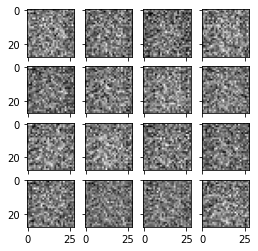

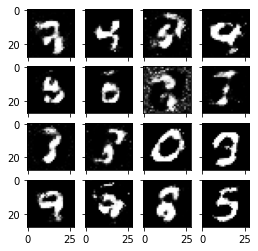

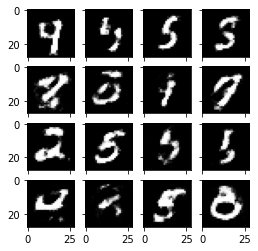

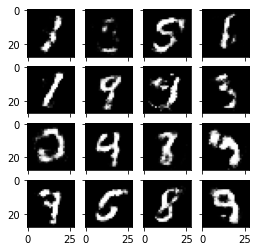

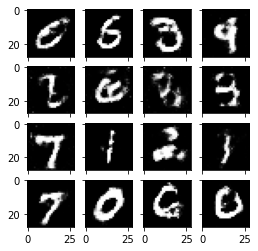

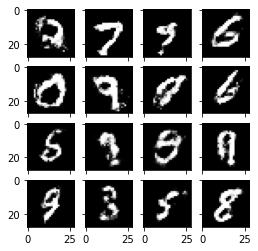

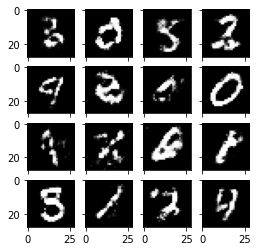

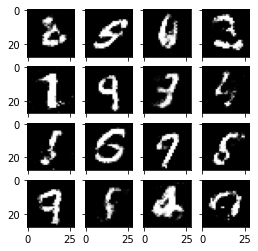

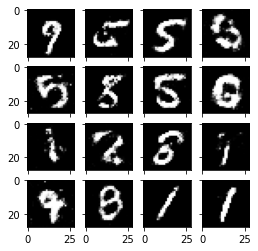

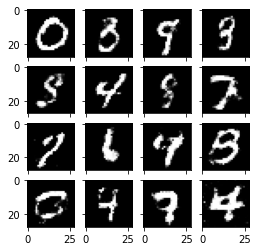

In [ ]:
losses = wgangp_train(5000,5,10,opt,128,500,disc_weight)

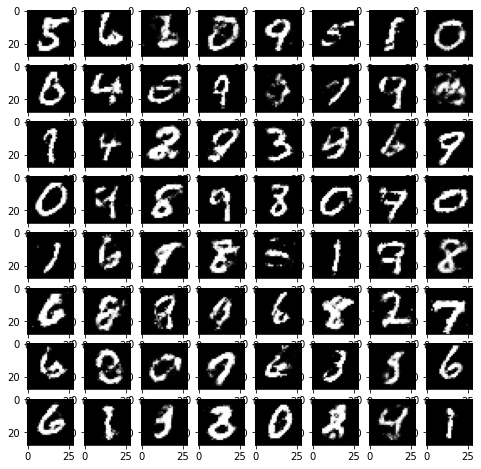

In [ ]:
fig,ax = plt.subplots(8,8,figsize=(8,8))

for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

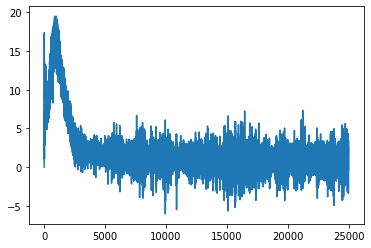

In [ ]:
losses = np.array(losses)
plt.plot(range(len(losses[:,0])),-losses[:,0])

## WGAN-GP DC-Generator Dense-Discriminator

In [ ]:
th = 0.05
z = 256
lr = 0.00005
 
discriminator = keras.Sequential()
discriminator.add(Reshape((784,),input_shape=(28,28,1)))
discriminator.add(Dense(1024))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(th))
discriminator.add(Dense(1))
 
discriminator.compile(loss = EM,optimizer = keras.optimizers.RMSprop(lr))
disc_weight = discriminator.trainable_weights
opt = keras.optimizers.RMSprop(lr)
discriminator.trainable = False
 
generator = keras.Sequential()
generator.add(Dense(7*7*256,input_dim = z))
generator.add(LeakyReLU(th))
generator.add(Reshape((7,7,256)))
generator.add(Conv2DTranspose(512,(5,5),(2,2),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(64,(5,5),(1,1),padding="same"))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(1,(5,5),(2,2),padding="same",activation = "tanh"))
 
gan = keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = EM,optimizer = keras.optimizers.RMSprop((0.0002)))
 
assert ((gan.layers[0].trainable==True) and (gan.layers[1].trainable==False))

0 [-13.609746932983398, 0.053553626]
1600 [-1.6525967121124268, 0.012470625]
3200 [-1.8608005046844482, 0.02254289]
4800 [-1.1667723655700684, 0.019857999]
6400 [-1.4383615255355835, 0.10100281]


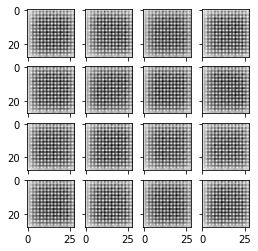

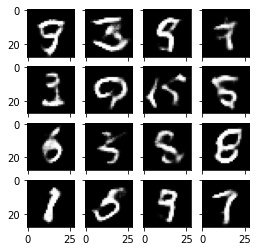

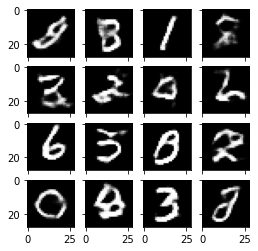

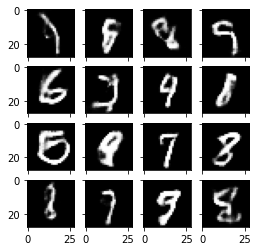

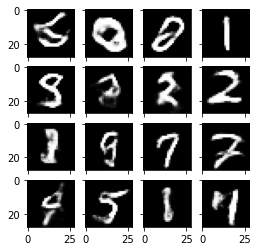

In [ ]:
losses = wgangp_train(8000,15,10,opt,32,1600,disc_weight)

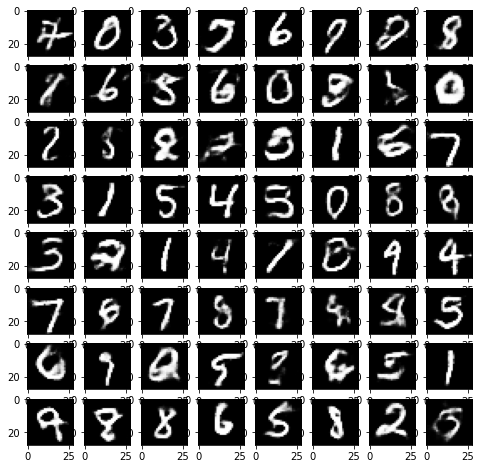

In [ ]:
fig,ax = plt.subplots(8,8,figsize=(8,8))
 
for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

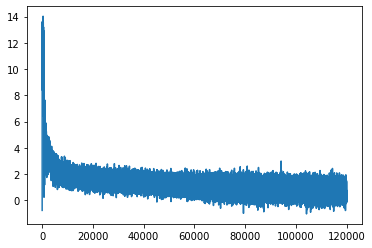

In [ ]:
losses = np.array(losses)
plt.plot(range(len(losses[:,0])),-losses[:,0])

## WGAN-GP DCGAN

In [ ]:
th = 0.2
z = 256
lr = 0.0005
 
discriminator = keras.Sequential()
discriminator.add(Conv2D(32,(5,5),(2,2),"same",input_shape=(28,28,1)))
discriminator.add(LeakyReLU(th))
discriminator.add(Conv2D(64,(3,3),(2,2),"same"))
discriminator.add(LeakyReLU(th))
discriminator.add(Conv2D(128,(3,3),(2,2),"same"))
discriminator.add(LeakyReLU(th))
discriminator.add(Flatten())
discriminator.add(Dense(1))
 
discriminator.compile(loss = EM,optimizer = keras.optimizers.RMSprop(lr))
disc_weight = discriminator.trainable_weights
opt = keras.optimizers.RMSprop(lr)
discriminator.trainable = False
 
generator = keras.Sequential()
generator.add(Dense(7*7*256,input_dim = z))
generator.add(LeakyReLU(th))
generator.add(Reshape((7,7,256)))
generator.add(Conv2DTranspose(512,(5,5),(2,2),padding="same"))
generator.add(BatchNormalization(axis=-1))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(64,(3,3),(1,1),padding="same"))
generator.add(BatchNormalization(axis=-1))
generator.add(LeakyReLU(th))
generator.add(Conv2DTranspose(1,(5,5),(2,2),padding="same",activation = "tanh"))
 
gan = keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = EM,optimizer = keras.optimizers.RMSprop((0.0005)))
 
assert ((gan.layers[0].trainable==True) and (gan.layers[1].trainable==False))

0 [-17.27693748474121, 14.471329]
1600 [-0.9928150177001953, 0.82331246]
3200 [-0.8861351013183594, 0.62129253]
4800 [-0.6414775848388672, 0.36881918]
6400 [-0.6392002105712891, 0.24268925]


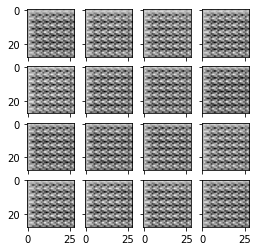

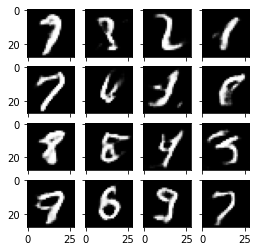

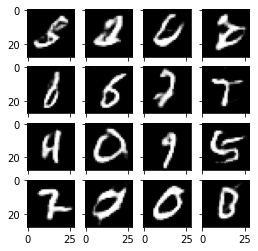

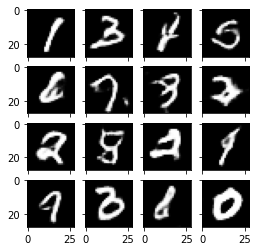

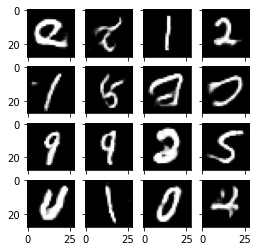

In [ ]:
losses = wgangp_train(8000,5,100,opt,64,1600,disc_weight)

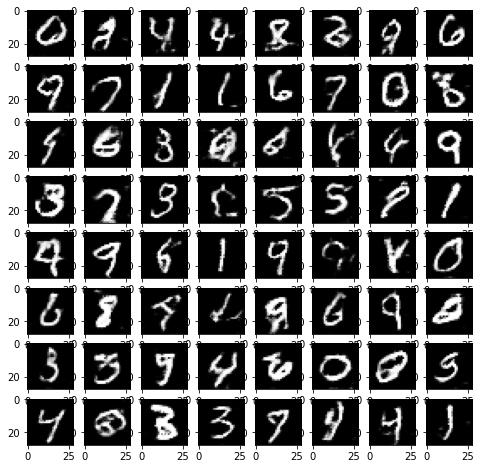

In [ ]:
fig,ax = plt.subplots(8,8,figsize=(8,8))
 
for i in range(64):
  ax[i%8,i//8].imshow(generator.predict(np.random.randn(1,z)).reshape((28,28)),cmap="gray")

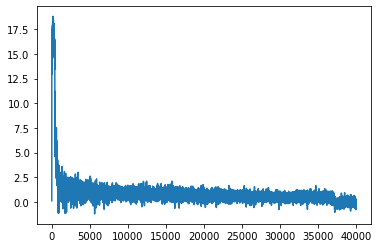

In [ ]:
losses = np.array(losses)
plt.plot(range(len(losses[:,0])),-losses[:,0])